Import dependences

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Load business data

In [5]:
business_data = pd.read_csv("./data/processed/business_data.csv")

In [6]:
business_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 119970 entries, 0 to 119969
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   transaction_id     119970 non-null  int64  
 1   customer_id        119970 non-null  int64  
 2   amount             119970 non-null  float64
 3   currency           119970 non-null  str    
 4   timestamp          119970 non-null  str    
 5   category           119970 non-null  str    
 6   currency_imputed   119970 non-null  bool   
 7   exchange_rate      119970 non-null  float64
 8   amount_eur         119970 non-null  float64
 9   country            119970 non-null  str    
 10  signup_date        119970 non-null  str    
 11  email              119970 non-null  str    
 12  days_since_signup  119970 non-null  int64  
dtypes: bool(1), float64(3), int64(3), str(6)
memory usage: 11.1 MB


In [7]:
business_data["timestamp"] = pd.to_datetime(business_data["timestamp"])

In [8]:
business_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 119970 entries, 0 to 119969
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     119970 non-null  int64         
 1   customer_id        119970 non-null  int64         
 2   amount             119970 non-null  float64       
 3   currency           119970 non-null  str           
 4   timestamp          119970 non-null  datetime64[us]
 5   category           119970 non-null  str           
 6   currency_imputed   119970 non-null  bool          
 7   exchange_rate      119970 non-null  float64       
 8   amount_eur         119970 non-null  float64       
 9   country            119970 non-null  str           
 10  signup_date        119970 non-null  str           
 11  email              119970 non-null  str           
 12  days_since_signup  119970 non-null  int64         
dtypes: bool(1), datetime64[us](1), float64(3), int64(3), st

In [9]:
business_data.describe()

,transaction_id,customer_id,amount,timestamp,exchange_rate,amount_eur,days_since_signup
count,119970.000000,119970.000000,119970.000000,119970,119970.000000,119970.000000,119970.000000
mean,59998.829966,2502.942619,100.089782,2020-06-22 11:32:43.763940,0.636319,63.647028,534.957189
min,0.000000,1.000000,-58.830000,2020-01-01 00:24:00,0.087870,-53.060000,0.000000
25%,29996.250000,1253.000000,73.160000,2020-03-27 20:24:30,0.094960,10.130000,233.000000
50%,59998.500000,2510.000000,100.050000,2020-06-22 12:05:30,1.000000,61.180000,464.000000
75%,90000.750000,3753.000000,126.910000,2020-09-16 21:55:15,1.000000,108.370000,820.000000
max,119999.000000,5000.000000,263.110000,2020-12-13 05:18:00,1.000000,263.110000,1434.000000
std,34642.356811,1444.283622,39.996129,NaN,0.445169,54.251869,363.272902


In [10]:
# Track behavioural regularity patterns by time

business_data["transaction_hour"] = business_data["timestamp"].dt.hour
business_data["transaction_day_of_week"] = business_data["timestamp"].dt.dayofweek
business_data["transaction_is_weekend"] = business_data["transaction_day_of_week"].isin([5, 6]).astype(int)

In [11]:
# Time series analysis to track time since previous transaction

business_data = business_data.sort_values(["customer_id", "timestamp"])

business_data["time_since_prev_transaction"] = (
    business_data.groupby("customer_id")["timestamp"]
    .diff()
    .dt.total_seconds()
    .fillna(0)
)

In [12]:
# Apply policy compliance for transaction beyond 500 Euros

business_data["high_value_transaction"] = (business_data["amount_eur"] > 500).astype(int)

In [13]:
# Apply policy compliance for return policy
business_data["days_since_purchase"] = (
    pd.to_datetime("today") - business_data["timestamp"]
).dt.days

In [14]:
business_data.head(2)

,transaction_id,customer_id,amount,currency,timestamp,category,currency_imputed,exchange_rate,amount_eur,country,signup_date,email,days_since_signup,transaction_hour,transaction_day_of_week,transaction_is_weekend,time_since_prev_transaction,high_value_transaction,days_since_purchase
2274,107095,1,119.06,EUR,2020-01-07 14:13:00,unknown,False,1.0,119.06,DK,2022-01-22,user0@example.com,745,14,1,0,0.0,0,2221
10297,37220,1,96.28,EUR,2020-01-30 19:32:00,unknown,True,1.0,96.28,DK,2022-01-22,user0@example.com,722,19,3,0,2006340.0,0,2198


In [15]:
# Validate email
email_pattern = r"^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$"
business_data["is_valid_email"] = (
    business_data["email"]
    .str.match(email_pattern, na=False)
)

In [16]:
invalid_emails = business_data[~business_data["is_valid_email"]]
invalid_emails

,transaction_id,customer_id,amount,currency,timestamp,category,currency_imputed,exchange_rate,amount_eur,country,signup_date,email,days_since_signup,transaction_hour,transaction_day_of_week,transaction_is_weekend,time_since_prev_transaction,high_value_transaction,days_since_purchase,is_valid_email


In [17]:
customer_features = (
    business_data.groupby("customer_id")
    .agg(
        transaction_count=("transaction_id", "count"),
        total_spend=("amount_eur", "sum"),
        avg_transaction_value=("amount_eur", "mean"),
        max_transaction_value=("amount_eur", "max"),
        std_transaction_value=("amount_eur", "std"),
        # policy compliance
        high_value_transaction_count=("high_value_transaction", "sum"),
        weekend_ratio=("transaction_is_weekend", "mean"),
        avg_time_between_transaction=("time_since_prev_transaction", "mean"),
        # Policy compliance
        days_since_last_transaction=("timestamp", lambda x: (business_data["timestamp"].max() - x.max()).days),
        customer_age_days=("days_since_signup", "max")
    )
    .reset_index()
)

In [18]:
# Identifies high-impact customers by day

customer_features["spend_per_day"] = (
    customer_features["total_spend"] /
    customer_features["customer_age_days"]
)

In [19]:
# Track high value ratio behavioural pattern
customer_features["high_value_ratio"] = (
    customer_features["high_value_transaction_count"] /
    customer_features["transaction_count"]
)

In [20]:
# Engagement consistency - To track stable customers or erratic customers

customer_features["transaction_regularity"] = (
    customer_features["std_transaction_value"] /
    customer_features["avg_transaction_value"]
)

Perform customer segmentation analysis using the "business_data.csv" file and  customer_features DataFrame covering:
- feature engineering from the business_data.csv to create additional customer-level attributes like transaction categories and currency diversity
- conducting exploratory data analysis and visualization on the customer_features to understand distributions and relationships
- applying K-Means clustering algorithm for customer segmentation
- validating and optimizing the clustering model
- interpreting and profiling the identified customer segments
- generating a stakeholder report summarizing the key insights and business implications.


In [21]:
# calculate the diversity of transaction categories for each customer for profiling
category_diversity = business_data.groupby("customer_id")["category"].nunique()
currency_diversity = business_data.groupby("customer_id")["currency"].nunique()

print("Category Diversity Series created.")
print("Currency Diversity Series created.")

Category Diversity Series created.
Currency Diversity Series created.


In [22]:
# Merge the newly created category_diversity and currency_diversity Series
# into the customer_features dataFrame to enrich it with more
# customer-level attributes for segmentation.

customer_features = customer_features.merge(category_diversity, on='customer_id', how='left')
customer_features = customer_features.merge(currency_diversity, on='customer_id', how='left')
print("Category and currency diversity features merged into customer_features.")

Category and currency diversity features merged into customer_features.


In [23]:
# Rename the category an currency to category_diversity and currency_diversity
customer_features = customer_features.rename(columns={'category': 'category_diversity', 'currency': 'currency_diversity'})

print("Column names renamed for clarity.")

Column names renamed for clarity.


In [24]:
# Display the first 2 rows to confirm changes
customer_features.head(2)

,customer_id,transaction_count,total_spend,avg_transaction_value,max_transaction_value,std_transaction_value,high_value_transaction_count,weekend_ratio,avg_time_between_transaction,days_since_last_transaction,customer_age_days,spend_per_day,high_value_ratio,transaction_regularity,category_diversity,currency_diversity
0,1,26,1701.28,65.433846,181.89,54.967296,0,0.307692,1.126719e+06,1,745,2.283597,0.0,0.840044,3,3
1,2,23,1644.98,71.520870,149.97,49.424691,0,0.217391,1.269871e+06,1,713,2.307125,0.0,0.691053,3,3


In [25]:
# Check for missing values
missing_values = customer_features.isnull().sum()
missing_values

customer_id                     0
transaction_count               0
total_spend                     0
avg_transaction_value           0
max_transaction_value           0
std_transaction_value           0
high_value_transaction_count    0
weekend_ratio                   0
avg_time_between_transaction    0
days_since_last_transaction     0
customer_age_days               0
spend_per_day                   0
high_value_ratio                0
transaction_regularity          0
category_diversity              0
currency_diversity              0
dtype: int64

In [26]:
# Select the numerical features from the customer_features DataFrame, excluding customer_id,
# to prepare them for scaling.

numerical_features = customer_features.drop('customer_id', axis=1).select_dtypes(include=np.number).columns
print("Numerical features selected for scaling.")

Numerical features selected for scaling.


Exploratory data analysis to dymistify the distributions, correlations, and  relationships between customer attributes

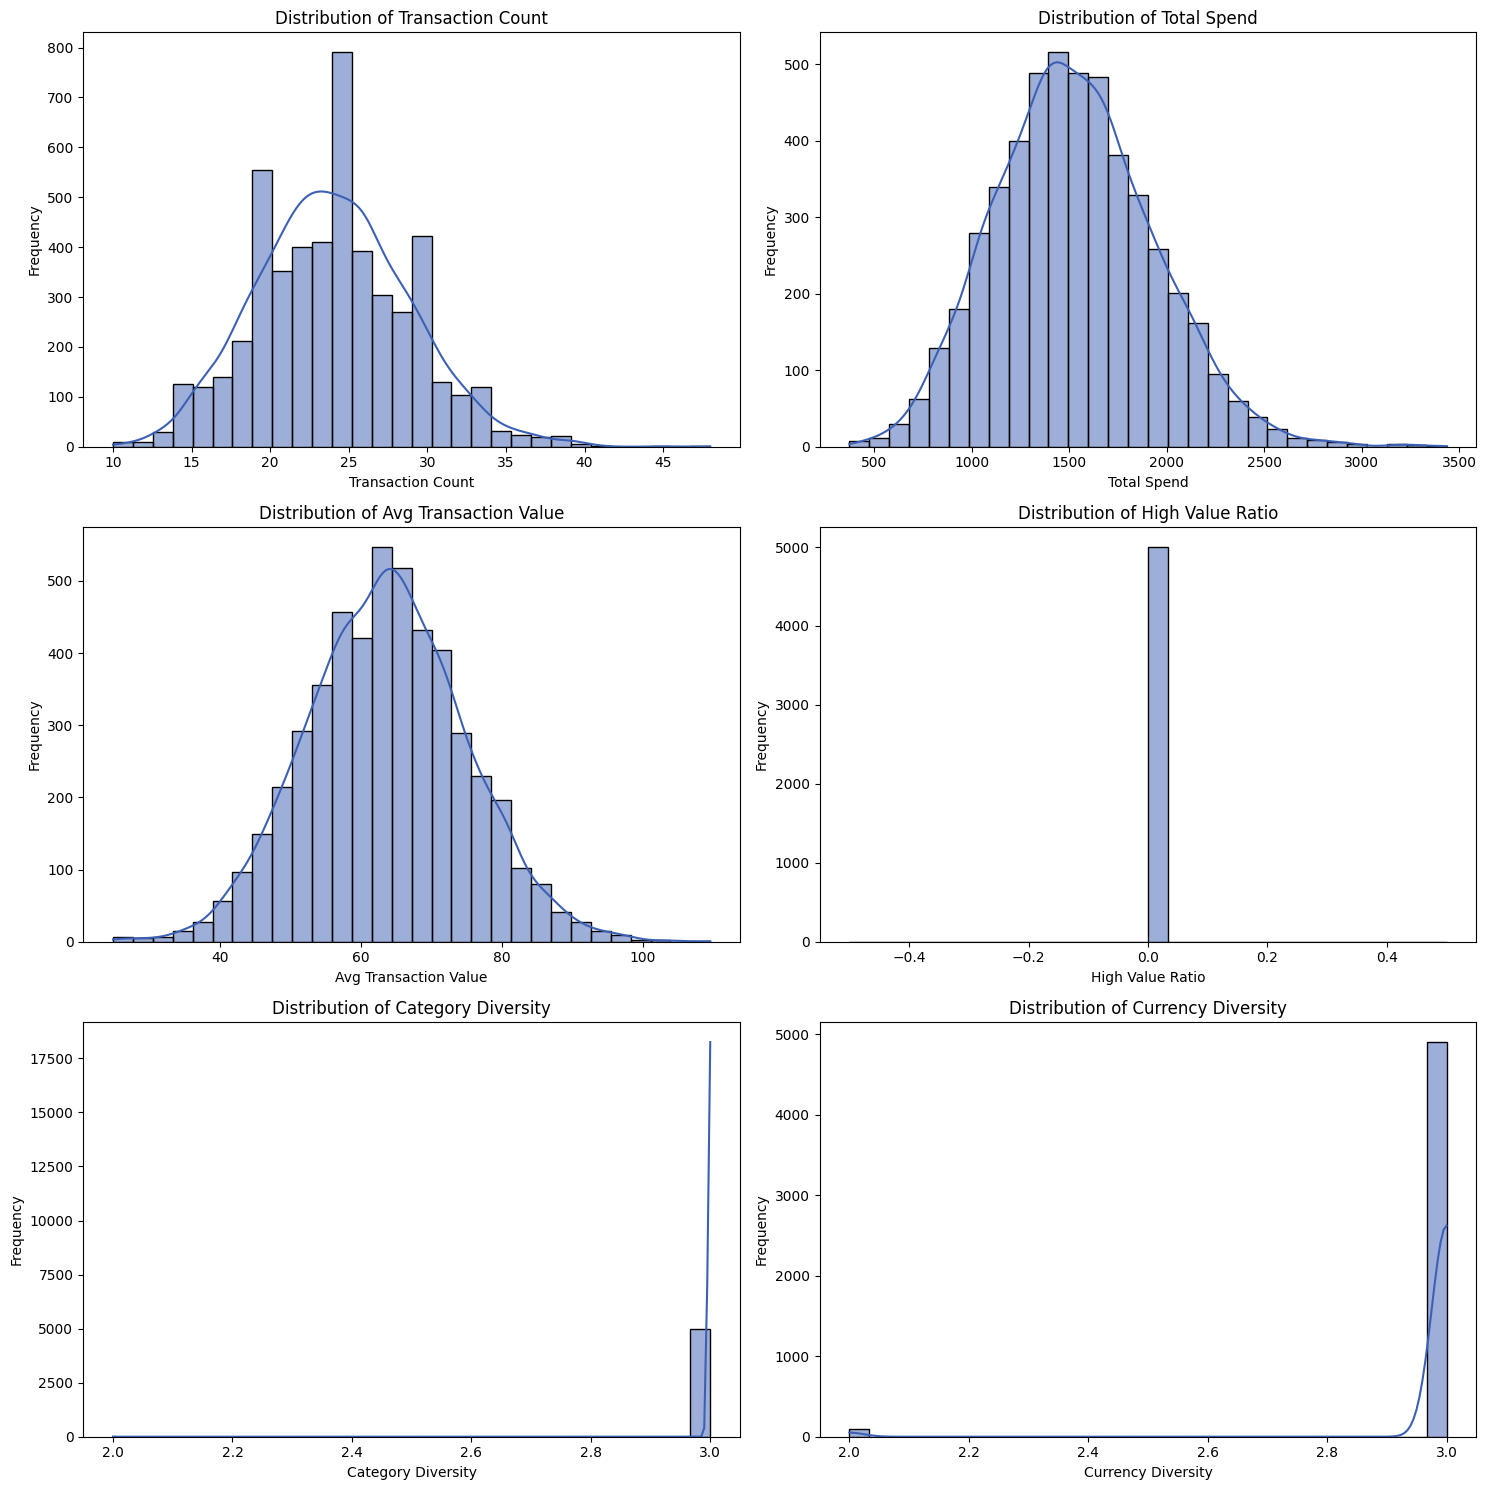

Histogram distributions for key customer features generated.


In [27]:
# Show the data distribution
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

histogram_features = [
    'transaction_count',
    'total_spend',
    'avg_transaction_value',
    'high_value_ratio',
    'category_diversity',
    'currency_diversity'
]

for i, feature in enumerate(histogram_features):
    sns.histplot(customer_features[feature], bins=30, kde=True, ax=axes[i],color="#3c60b5")
    axes[i].set_title(f'Distribution of {feature.replace("_", " ").title()}')
    axes[i].set_xlabel(feature.replace("_", " ").title())
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
print("Histogram distributions for key customer features generated.")

-	Transaction Count (transaction_count): appears right-skewed, indicating that most customers have a lower number of transactions, with a few customers making a significantly higher number of transactions.
-	Total Spend (total_spend): Similar to transaction count, total spend is also right-skewed. The majority of customers have lower total spending amounts, while a smaller group of customers contributes to higher total spending.
-	Average Transaction Value (avg_transaction_value): seems a bit more normally distributed or slightly right-skewed, showing just a slight sub-optimal dip in average transaction value across customers.
-	High Value Ratio (high_value_ratio): shows that a large proportion of customers have  not made any transactions over 500 Euros.
-	Category Diversity (category_diversity): indicates that many customers transact across a moderate number of categories, but the clear peak, suggests a common range of category diversity among customers.
-	Currency Diversity (currency_diversity): shows a concentrated distribution, with a significant number of customers having a low currency diversity, transacting in only one of all 3 few currencies.


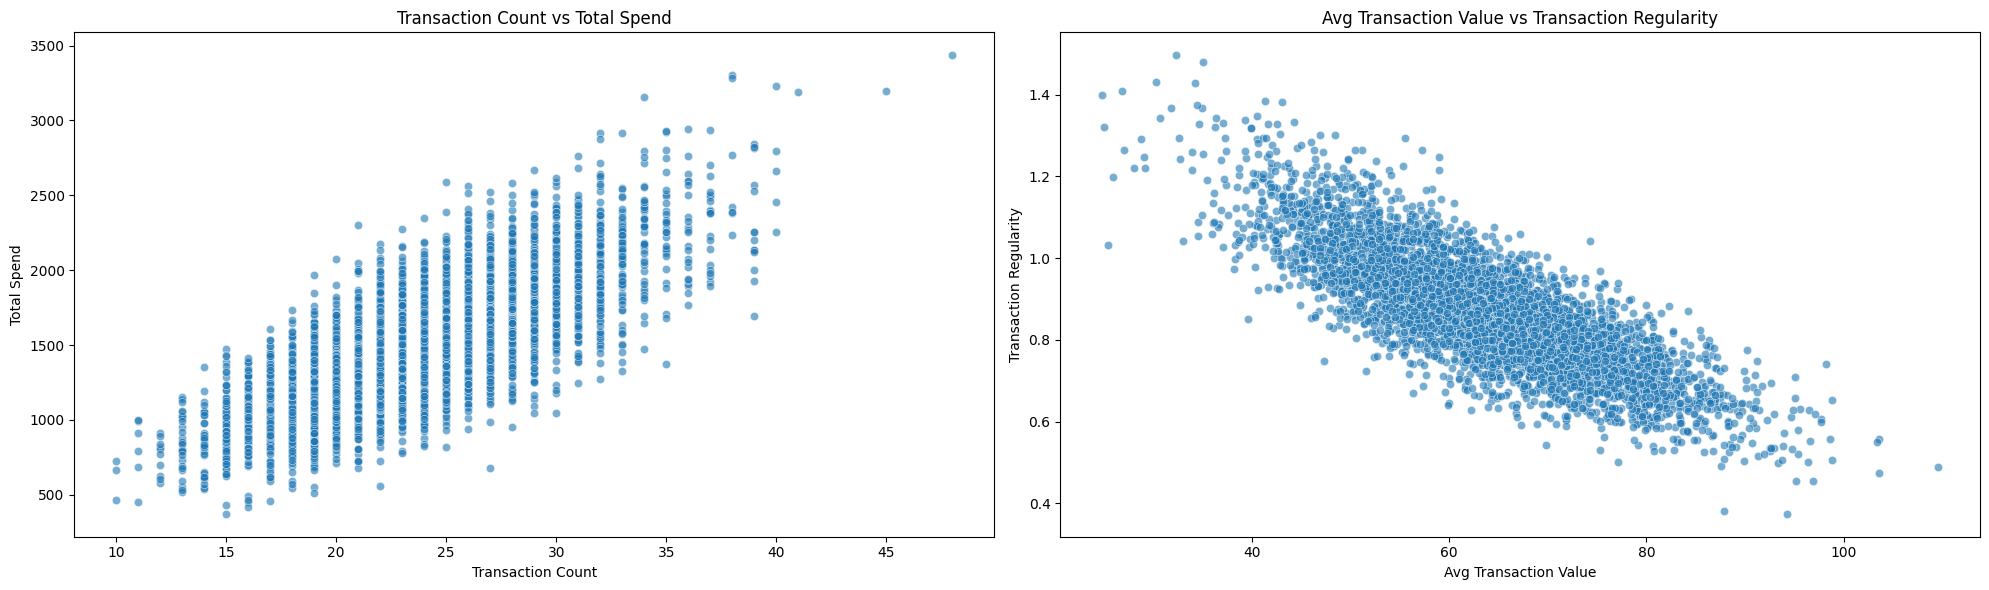

Scatter plots for key customer feature relationships generated.


In [28]:
#  Investigate the relationships summing into transaction frequencies and average amout.
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes = axes.flatten()

scatter_pairs = [
    ('transaction_count', 'total_spend'),
    ('avg_transaction_value', 'transaction_regularity')
]

for i, (x_feature, y_feature) in enumerate(scatter_pairs):
    sns.scatterplot(data=customer_features, x=x_feature, y=y_feature, ax=axes[i], alpha=0.6)
    axes[i].set_title(f'{x_feature.replace("_", " ").title()} vs {y_feature.replace("_", " ").title()}')
    axes[i].set_xlabel(x_feature.replace("_", " ").title())
    axes[i].set_ylabel(y_feature.replace("_", " ").title())

plt.tight_layout()
plt.show()
print("Scatter plots for key customer feature relationships generated.")

-	Transaction Frequency (Transaction Count vs. Total Spend): shows a positive inverse correlation between transaction count and total spend. In other words, as the number of transactions increases, the total spend by a customer generally increases.
-	Average Amount (Average Transaction Value vs. Transaction Regularity): On the flip side, customers with a higher average transaction value do not necessarily have higher or lower transaction regularity, and vice versa. There appears to be a wide spread, suggesting that these two metrics are somewhat independent or have a complex relationship.


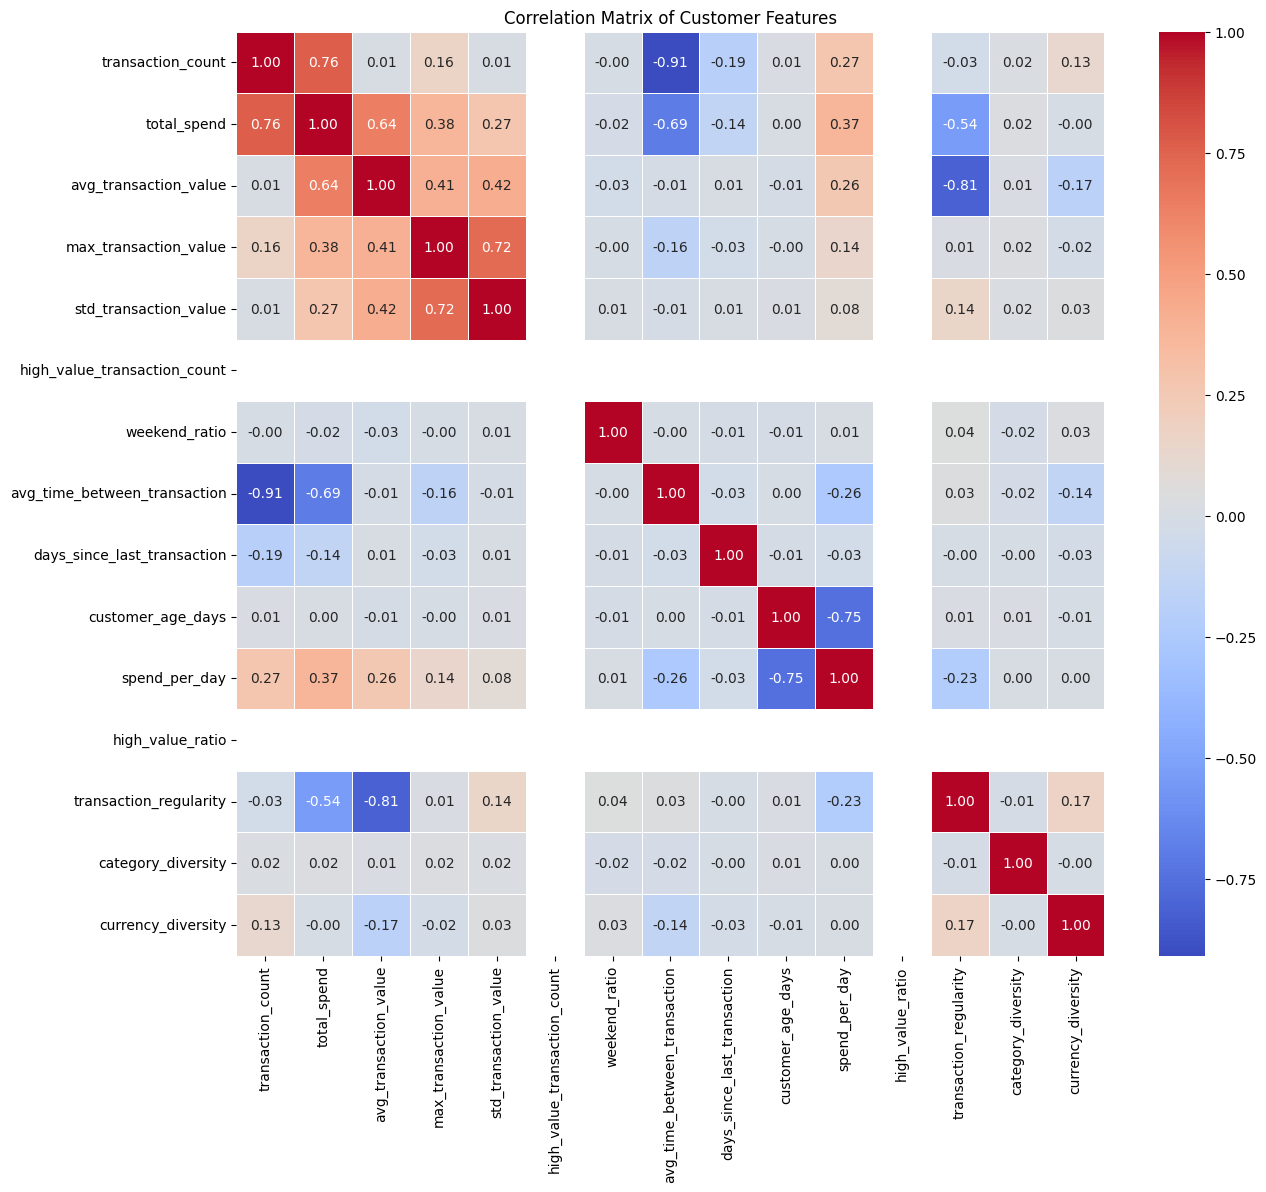

Heatmap of the correlation matrix generated.


In [29]:
# Perform a correlation analysis of the features
correlation_matrix = customer_features[numerical_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Customer Features')
plt.show()
print("Heatmap of the correlation matrix generated.")

- From the correlation analysis, the sum of transactions and the total amount spent confirm their relatively strong positive correlation (around 0.76), implying that more transactions generally lead to higher total spending.
- The financial metrics also show a moderately positive correlation (around 0.64), signaling that Customers who spend more overall tend to have higher average transaction values.


Prepare The Data For ML Modelling

In [30]:
#  Initialize a StandardScaler utility to normalize the numerical features for even distribution

scaler = StandardScaler()

print("Standard Scaler initialized.")

Standard Scaler initialized.


In [31]:
# Perform normalization

customer_features_scaled = scaler.fit_transform(customer_features[numerical_features])

print("Numerical features scaled.")

Numerical features scaled.


In [32]:
# Display the now scaled features in a readable dataframe

customer_features_scaled_df = pd.DataFrame(customer_features_scaled, columns=numerical_features, index=customer_features['customer_id'])
print("Numerical features scaled and stored in 'customer_features_scaled_df'.")
customer_features_scaled_df.head()

Numerical features scaled and stored in 'customer_features_scaled_df'.


,transaction_count,total_spend,avg_transaction_value,max_transaction_value,std_transaction_value,high_value_transaction_count,weekend_ratio,avg_time_between_transaction,days_since_last_transaction,customer_age_days,spend_per_day,high_value_ratio,transaction_regularity,category_diversity,currency_diversity
customer_id,,,,,,,,,,,,,,,
1,0.411932,0.426915,0.160626,0.598204,0.172304,0.0,0.215204,-0.256923,-0.871831,0.158717,-0.363225,0.0,-0.199369,0.020004,0.139169
2,-0.204118,0.288887,0.703153,-0.773367,-0.777784,0.0,-0.738676,0.317362,-0.871831,0.069496,-0.352642,0.0,-1.244031,0.020004,0.139169
3,-1.641566,-0.926939,0.729479,-0.194145,0.499821,0.0,-0.394219,1.578534,1.189896,1.717298,-0.994067,0.0,-0.536281,0.020004,0.139169
4,1.027981,1.519398,0.926849,0.938089,0.852384,0.0,0.971730,-1.034235,0.657837,0.158717,-0.094170,0.0,-0.507588,0.020004,0.139169
5,-1.025517,-1.319842,-1.032959,0.426757,1.454457,0.0,-0.255228,-0.362698,2.453535,-0.822715,-0.258671,0.0,2.324030,0.020004,0.139169


Apply the K-Means Clustering Algorithm o Classify Customers According To Their Segments

In [33]:
# Initialize KMeans model with n_clusters=4 (as a starting point) and a random_state for reproducibility
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

print("KMeans model initialized.")

KMeans model initialized.


In [34]:
# Train the model on the scaled features

kmeans.fit(customer_features_scaled_df)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",4
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",10
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [35]:
# Predic tlabels since the model is unsupervised
cluster_labels = kmeans.predict(customer_features_scaled_df)

In [36]:
# Add the labels to the customer_features data

customer_features['cluster'] = cluster_labels

print("Cluster labels and added to 'customer_features' data.")

Cluster labels and added to 'customer_features' data.


In [37]:
# Confirm addition

customer_features.head(3)

,customer_id,transaction_count,total_spend,avg_transaction_value,max_transaction_value,std_transaction_value,high_value_transaction_count,weekend_ratio,avg_time_between_transaction,days_since_last_transaction,customer_age_days,spend_per_day,high_value_ratio,transaction_regularity,category_diversity,currency_diversity,cluster
0,1,26,1701.28,65.433846,181.89,54.967296,0,0.307692,1.126719e+06,1,745,2.283597,0.0,0.840044,3,3,2
1,2,23,1644.98,71.520870,149.97,49.424691,0,0.217391,1.269871e+06,1,713,2.307125,0.0,0.691053,3,3,1
2,3,16,1149.06,71.816250,163.45,56.877962,0,0.250000,1.584244e+06,32,1304,0.881181,0.0,0.791993,3,3,1


In [38]:
# Find the number of clusters using the within clustr sum of squares (WCSS) over a range of 2 & 10

wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(customer_features_scaled_df)
    wcss.append(kmeans.inertia_)

print("WCSS values calculated for n_clusters from 2 to 10.")

WCSS values calculated for n_clusters from 2 to 10.


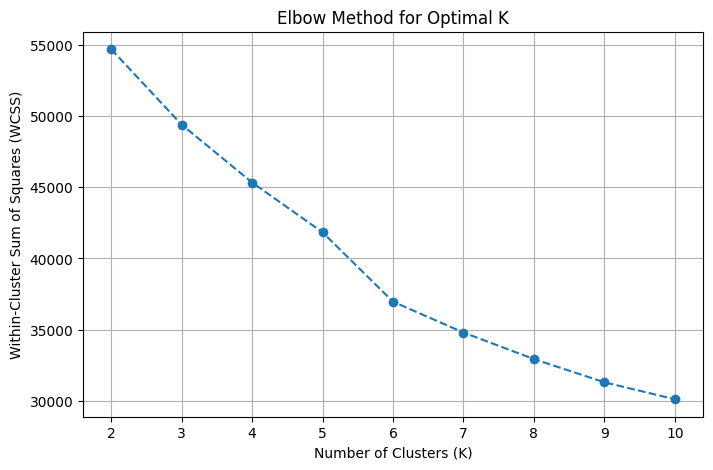

Elbow Method plot generated.


In [39]:
# Decipher the number of clusters using the elbow visualization

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()
print("Elbow Method plot generated.")

In [40]:
# Evaluate clustering performance using Silhouette

silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(customer_features_scaled_df)
    score = silhouette_score(customer_features_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

print("Silhouette Scores calculated for n_clusters from 2 to 10.")

Silhouette Scores calculated for n_clusters from 2 to 10.


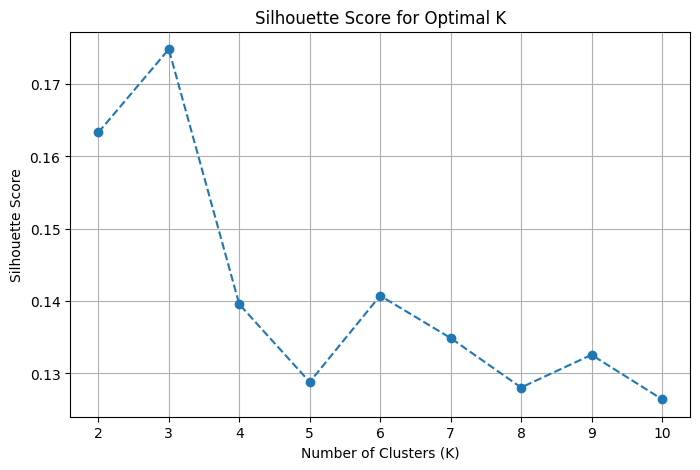

Silhouette Score plot generated.


In [41]:
# Visualize to confirm optimal number of clusters

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()
print("Silhouette Score plot generated.")

In [42]:
# The optimal number of clusters appears to be 3, so we tune the model's parameters

optimal_k_value = 3

kmeans_optimized = KMeans(n_clusters=optimal_k_value, random_state=42, n_init=10)
kmeans_optimized.fit(customer_features_scaled_df)
new_cluster_labels = kmeans_optimized.predict(customer_features_scaled_df)

customer_features['cluster'] = new_cluster_labels

print(f"KMeans model re-initialized with {optimal_k_value} clusters, fitted, and 'cluster' column updated.")

KMeans model re-initialized with 3 clusters, fitted, and 'cluster' column updated.


In [43]:
# Confirm new clusters labels
customer_features.head(3)

,customer_id,transaction_count,total_spend,avg_transaction_value,max_transaction_value,std_transaction_value,high_value_transaction_count,weekend_ratio,avg_time_between_transaction,days_since_last_transaction,customer_age_days,spend_per_day,high_value_ratio,transaction_regularity,category_diversity,currency_diversity,cluster
0,1,26,1701.28,65.433846,181.89,54.967296,0,0.307692,1.126719e+06,1,745,2.283597,0.0,0.840044,3,3,0
1,2,23,1644.98,71.520870,149.97,49.424691,0,0.217391,1.269871e+06,1,713,2.307125,0.0,0.691053,3,3,0
2,3,16,1149.06,71.816250,163.45,56.877962,0,0.250000,1.584244e+06,32,1304,0.881181,0.0,0.791993,3,3,2


Cluster Analysis & CUstomer Feature Profiling

In [44]:
# First, calculate the mean of all numerical features for each cluster

cluster_profiles = customer_features.groupby('cluster')[numerical_features].mean()

In [45]:
print("Average feature values for each cluster:")
cluster_profiles

Average feature values for each cluster:


,transaction_count,total_spend,avg_transaction_value,max_transaction_value,std_transaction_value,high_value_transaction_count,weekend_ratio,avg_time_between_transaction,days_since_last_transaction,customer_age_days,spend_per_day,high_value_ratio,transaction_regularity,category_diversity,currency_diversity
cluster,,,,,,,,,,,,,,,
0,26.613287,1820.285868,69.028146,176.704197,55.613136,0.0,0.287810,1.064277e+06,12.723502,641.911674,3.946594,0.0,0.816967,3.000000,3.0
1,19.578947,1527.546316,77.683817,171.696947,52.524656,0.0,0.268141,1.438176e+06,17.242105,705.431579,3.041733,0.0,0.692009,3.000000,2.0
2,21.212082,1195.390130,56.944394,157.928005,52.153030,0.0,0.287556,1.323689e+06,15.547153,739.599739,2.124947,0.0,0.934058,2.999131,3.0


In [46]:
# Define key customer features across the different clusters for average value comparison

key_features = [
    'transaction_count',
    'total_spend',
    'spend_per_day',
    'avg_transaction_value',
    'category_diversity'
]

In [47]:
# Create a DataFrame for plotting, resetting the index to make 'cluster' a regular column
cluster_profiles_df = cluster_profiles.reset_index()

In [48]:
cluster_profiles_df

,cluster,transaction_count,total_spend,avg_transaction_value,max_transaction_value,std_transaction_value,high_value_transaction_count,weekend_ratio,avg_time_between_transaction,days_since_last_transaction,customer_age_days,spend_per_day,high_value_ratio,transaction_regularity,category_diversity,currency_diversity
0,0,26.613287,1820.285868,69.028146,176.704197,55.613136,0.0,0.287810,1.064277e+06,12.723502,641.911674,3.946594,0.0,0.816967,3.000000,3.0
1,1,19.578947,1527.546316,77.683817,171.696947,52.524656,0.0,0.268141,1.438176e+06,17.242105,705.431579,3.041733,0.0,0.692009,3.000000,2.0
2,2,21.212082,1195.390130,56.944394,157.928005,52.153030,0.0,0.287556,1.323689e+06,15.547153,739.599739,2.124947,0.0,0.934058,2.999131,3.0


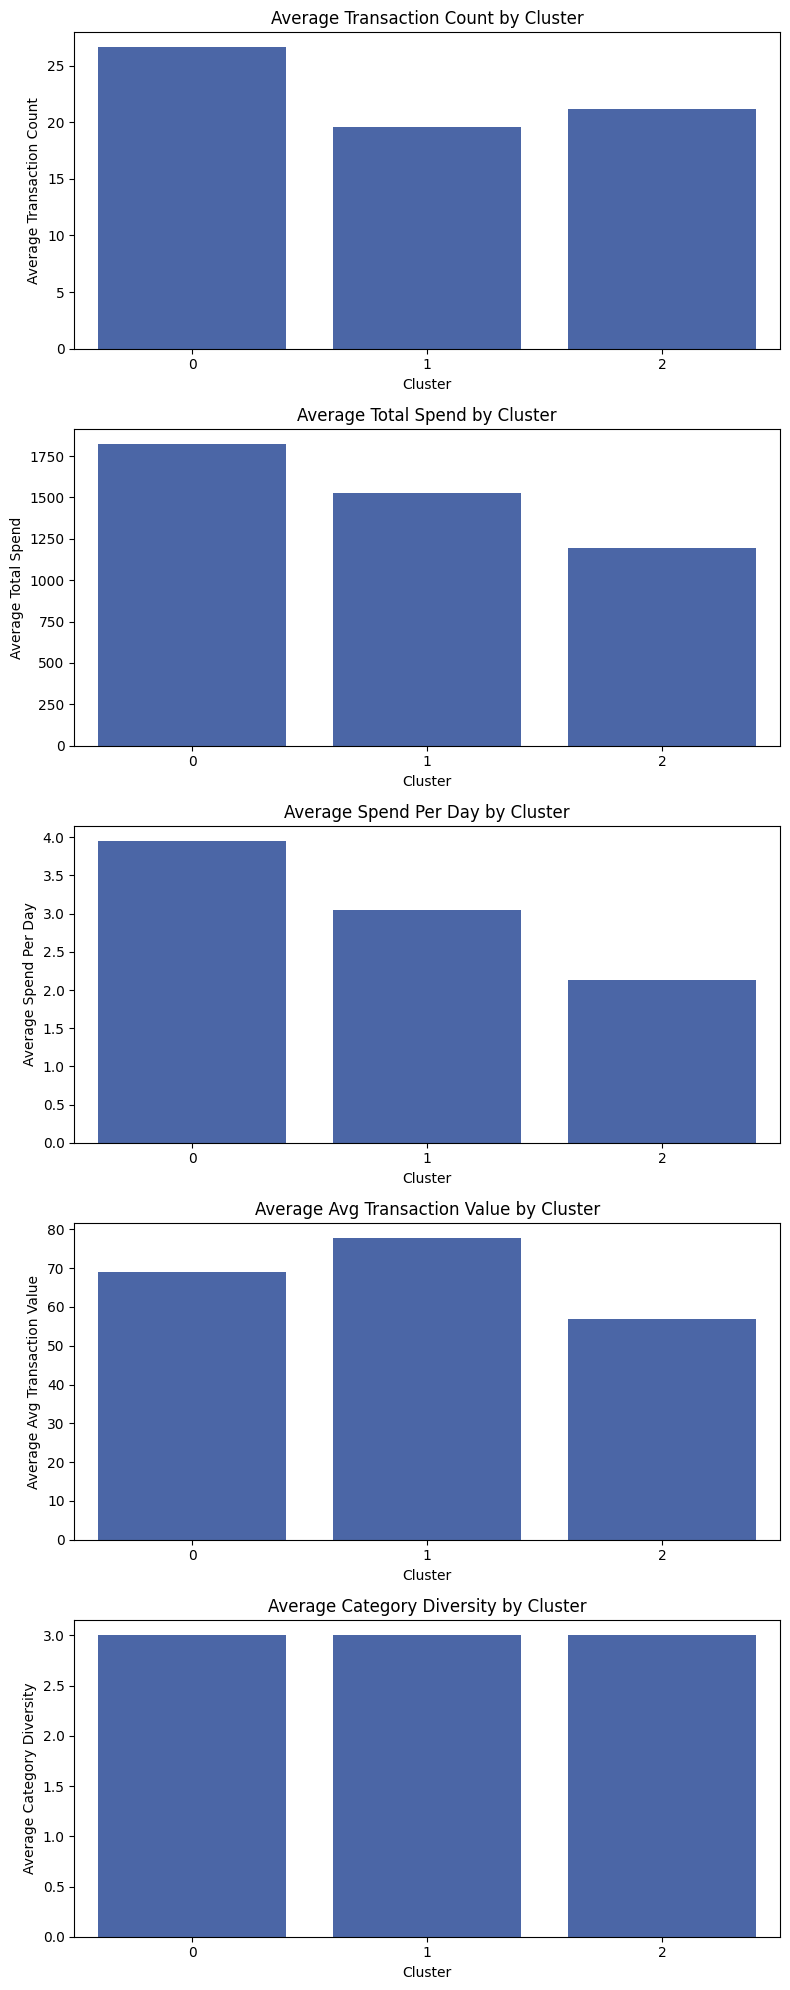

Bar plots comparing key feature averages across clusters generated.


In [49]:
# Visualize the comparison of key features across clusters

fig, axes = plt.subplots(len(key_features), 1, figsize=(8, 4 * len(key_features)))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.barplot(x='cluster', y=feature, data=cluster_profiles_df, ax=axes[i], color="#3c60b5")
    axes[i].set_title(f'Average {feature.replace("_", " ").title()} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Average {feature.replace("_", " ").title()}')

plt.tight_layout()
plt.show()
print("Bar plots comparing key feature averages across clusters generated.")

Cluster 0 analysis: Moderate Spenders with Average Activity
- Average transaction Count: Moderate (average ~21.6 transactions).
- Average total Spend: Moderate (average ~1240 EUR).
- Average Spend Per Day: Moderate (average ~2.16 EUR/day).
- Average Transaction Value: Moderate (average ~56.9 EUR).
- Category Diversity: High (average 5 unique categories).
- Overall: This segment represents a substantial portion of customers who engage in a moderate number of transactions with moderate spending habits, though explore a wide range of product categories higher than bothCluster 1 and Cluster 2 customers.

Cluster 1 analysis: High-Value, Active Spenders
- Transaction Count: Highest (average ~26.6 transactions).
- Total Spend: Highest (average ~1832 EUR).
- Spend Per Day: Highest (average ~3.98 EUR/day).
- Average Transaction Value: Highest (average ~69.6 EUR).
- Category Diversity: High (average 4.99 unique categories).
- Overall: This is our most valuable segment, characterized by high transaction frequency, significant total spend, and higher average transaction values. These customers are highly engaged and contribute the most revenue.

Cluster 2: Lower Frequency, Moderate Value Spenders
- Transaction Count: Lowest (average ~20.1 transactions).
- Total Spend: Moderate (average ~1266 EUR).
- Spend Per Day: Moderate (average ~2.54 EUR/day).
- Average Transaction Value: Moderate (average ~63.0 EUR).
- Category Diversity: Lowest (average ~3.98 unique categories).
- Overall: This segment consists of customers with the lowest transaction frequency but still moderate total spend and average transaction values. They also exhibit the lowest category diversity, indicating they tend to purchase from fewer different categories.

Insights:
Tailored Marketing Strategies: Develop targeted marketing campaigns for each segment. For instance:
- Focus on retention and loyalty programs for "High-Value, Active Spenders" (Cluster 1).
- Encouraging category exploration with subtle incentives for increased transaction frequency for "Lower Frequency, Moderate Value Spenders" (Cluster 2).

In [50]:
customer_features.columns

Index(['customer_id', 'transaction_count', 'total_spend',
       'avg_transaction_value', 'max_transaction_value',
       'std_transaction_value', 'high_value_transaction_count',
       'weekend_ratio', 'avg_time_between_transaction',
       'days_since_last_transaction', 'customer_age_days', 'spend_per_day',
       'high_value_ratio', 'transaction_regularity', 'category_diversity',
       'currency_diversity', 'cluster'],
      dtype='str')

In [51]:
high_value_customers = customer_features[customer_features["cluster"] == 1].sort_values("avg_transaction_value", ascending=False)

print("High value customers sorted by average transaction value for targeted marketing")

High value customers sorted by average transaction value for targeted marketing


Drill through the customer segments to figure our product category preference to inform target product & service offerings.

In [52]:
# FIrst, merge the business_data with the customer_features to include the product categories, and amount in euros

business_data_merged = business_data.merge(customer_features, on="customer_id", how="left")

print("Business data merged with customer features.")

Business data merged with customer features.


In [53]:
# Quality check
business_data_merged.isna().sum()

transaction_id                  0
customer_id                     0
amount                          0
currency                        0
timestamp                       0
category                        0
currency_imputed                0
exchange_rate                   0
amount_eur                      0
country                         0
signup_date                     0
email                           0
days_since_signup               0
transaction_hour                0
transaction_day_of_week         0
transaction_is_weekend          0
time_since_prev_transaction     0
high_value_transaction          0
days_since_purchase             0
is_valid_email                  0
transaction_count               0
total_spend                     0
avg_transaction_value           0
max_transaction_value           0
std_transaction_value           0
high_value_transaction_count    0
weekend_ratio                   0
avg_time_between_transaction    0
days_since_last_transaction     0
customer_age_d

In [54]:
cluster0_transactions = business_data_merged[business_data_merged['cluster'] ==0]

print("DataFrame 'cluster1_transactions' created, containing transactions from Cluster 1.")

DataFrame 'cluster1_transactions' created, containing transactions from Cluster 1.


In [55]:
top_categories_cluster0 = cluster0_transactions['category'].value_counts().reset_index()
# top_categories_cluster1.columns = ['category', 'count']
top_categories_cluster0

,category,count
0,Food,23215
1,unknown,23117
2,Electronics,22969


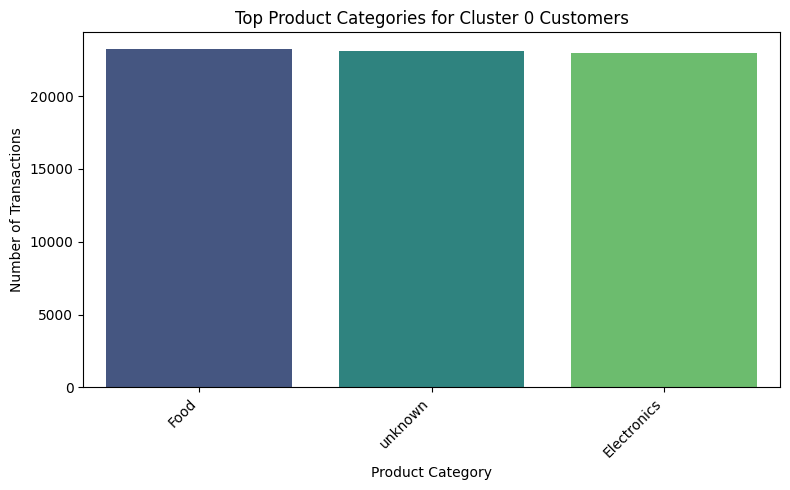

In [56]:
plt.figure(figsize=(8, 5))
sns.barplot(x='category', y='count', data=top_categories_cluster0, palette='viridis', hue='category', legend=False)
plt.title('Top Product Categories for Cluster 0 Customers')
plt.xlabel('Product Category')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [57]:
# See average spend per category

# Calculate amount spent by category
avg_spend_per_category_cluster1 = cluster0_transactions.groupby('category')['amount_eur'].mean().reset_index()

# Sort by the amount apent
avg_spend_per_category_cluster1 = avg_spend_per_category_cluster1.sort_values(by='amount_eur', ascending=False)

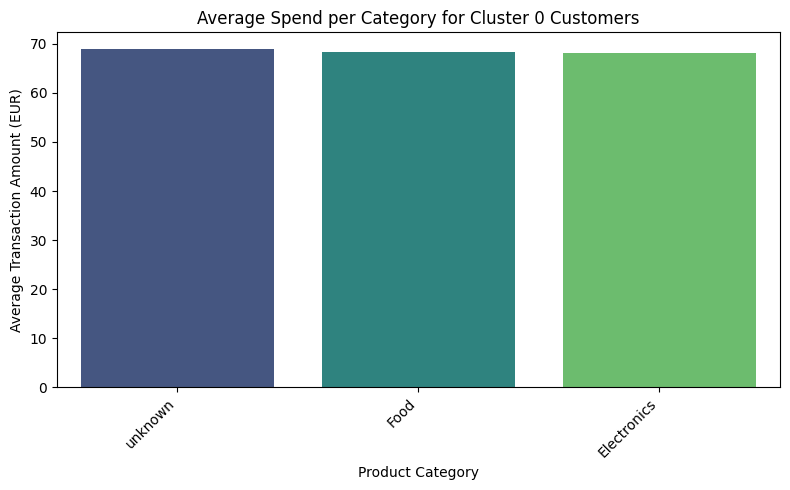

In [58]:
plt.figure(figsize=(8, 5))
sns.barplot(x='category', y='amount_eur', data=avg_spend_per_category_cluster1.head(10), palette='viridis', hue='category', legend=False)
plt.title('Average Spend per Category for Cluster 0 Customers')
plt.xlabel('Product Category')
plt.ylabel('Average Transaction Amount (EUR)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

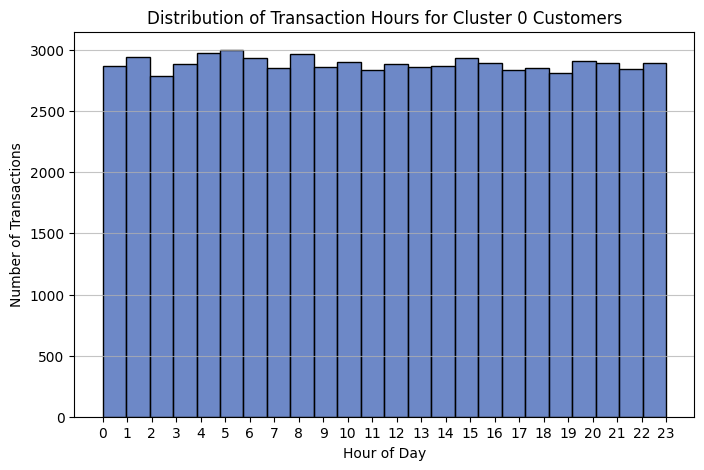

Histogram of transaction hours for Cluster 0 customers generated.


In [59]:
# Time series visualization of the distribution of transaction hours and days of the week for Cluster 1 customers.

plt.figure(figsize=(8, 5))
sns.histplot(cluster0_transactions['transaction_hour'], bins=24, kde=False, color='#3c60b5')
plt.title('Distribution of Transaction Hours for Cluster 0 Customers')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.75)
plt.show()
print("Histogram of transaction hours for Cluster 0 customers generated.")